使用之前5天的数据，对之后48小时的空气质量进行预测，模型如下

![](http://p3rz3gu1u.bkt.clouddn.com/2018-04-19-seq2seq_model.png)
<caption><center> **Figure 1**: lstm model</center></caption>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import seaborn as sns
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

from utils.plot_util import plot_forecast_and_actual_example
from metrics.metrics import SMAPE_on_dataset_v1
from seq2seq.seq2seq_data_util import get_training_statistics, generate_training_set, generate_dev_set
from seq2seq.multi_variable_seq2seq_model_parameters import build_graph

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

gpu_config = tf.ConfigProto()
gpu_config.gpu_options.allow_growth = True
session = tf.Session(config=gpu_config)
KTF.set_session(session)

### 2. Args

多变量版本

In [4]:
station_list = ['dongsi_aq','tiantan_aq','guanyuan_aq','wanshouxigong_aq','aotizhongxin_aq',
            'nongzhanguan_aq','wanliu_aq','beibuxinqu_aq','zhiwuyuan_aq','fengtaihuayuan_aq',
            'yungang_aq','gucheng_aq','fangshan_aq','daxing_aq','yizhuang_aq','tongzhou_aq',
            'shunyi_aq','pingchang_aq','mentougou_aq','pinggu_aq','huairou_aq','miyun_aq',
            'yanqin_aq','dingling_aq','badaling_aq','miyunshuiku_aq','donggaocun_aq',
            'yongledian_aq','yufa_aq','liulihe_aq','qianmen_aq','yongdingmennei_aq',
            'xizhimenbei_aq','nansanhuan_aq','dongsihuan_aq']            
X_aq_list = ["PM2.5","PM10","O3","CO","SO2","NO2"]  
y_aq_list = ["PM2.5","PM10","O3"]
X_meo_list = ["temperature","pressure","humidity","direction","speed/kph"]
use_day=True
pre_days=5
batch_size=128

少变量版本（测试）

In [5]:
# station_list = ['aotizhongxin_aq']            
# X_aq_list = ["PM2.5","PM10","O3","CO","SO2","NO2"]  
# y_aq_list = ["PM2.5"]
# X_meo_list = ["temperature","pressure","humidity","direction","speed/kph"]
# use_day = True
# pre_days = 5
# batch_size = 128

### 3. Prepare test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [6]:
test_x, test_y = generate_dev_set(station_list=station_list,
                                  X_aq_list=X_aq_list, 
                                  y_aq_list=y_aq_list, 
                                  X_meo_list=None,
                                  pre_days=pre_days)

In [7]:
print(test_x.shape, test_y.shape)

(17, 120, 210) (17, 48, 105)


尝试生成一个训练样本，确保是我们想要的尺寸。

In [8]:
X_training_batch, y_training_batch = generate_training_set(station_list=station_list,
                                                           X_aq_list=X_aq_list,
                                                           y_aq_list=y_aq_list,
                                                           pre_days=pre_days,
                                                           X_meo_list=None,
                                                           use_day=True,
                                                           batch_size=batch_size)
print(X_training_batch.shape, y_training_batch.shape)

(128, 120, 210) (128, 48, 105)


### 4. Build the model and train the model 

In [17]:
input_seq_len = pre_days * 24
output_seq_len = 48
hidden_dim = 512
input_dim = 210
output_dim = 105
num_stacked_layers = 3

learning_rate=1e-3
lambda_l2_reg=0.003
GRADIENT_CLIPPING=2.5
total_iteractions = 1000
KEEP_RATE = 0.5

In [18]:
rnn_model = build_graph(feed_previous=False, 
                        input_seq_len=input_seq_len, 
                        output_seq_len=output_seq_len, 
                        hidden_dim=hidden_dim, 
                        input_dim=input_dim, 
                        output_dim=output_dim, 
                        num_stacked_layers=num_stacked_layers, 
                        learning_rate=learning_rate,
                        lambda_l2_reg=lambda_l2_reg,
                        GRADIENT_CLIPPING=GRADIENT_CLIPPING)

In [19]:
train_losses = []
val_losses = []

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    losses = []
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_training_set(station_list,
                                                          X_aq_list,
                                                          y_aq_list,
                                                          X_meo_list=None,
                                                          use_day=use_day,
                                                          pre_days=pre_days,
                                                          batch_size=batch_size)

        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t,:] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t,:] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict) 
        
        if i%10 == 0:
            print("loss after %d/%d iteractions : %.3f" %(i, total_iteractions, loss_t))
            
            # 想要对训练过程中训练集的 smape 进行监督，发现模型并不是处在“预测”的状态，因此放弃
            # train_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
            # train_preds = [np.expand_dims(pred, 1) for pred in train_preds]
            # train_preds = np.concatenate(train_preds, axis = 1)
            
        losses.append(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./seq2seq/new_multi_variable_model_results/', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)

Training losses: 
loss after 0/1000 iteractions : 154.331
loss after 10/1000 iteractions : 78.756
loss after 20/1000 iteractions : 72.685
loss after 30/1000 iteractions : 69.706
loss after 40/1000 iteractions : 67.978
loss after 50/1000 iteractions : 64.692
loss after 60/1000 iteractions : 62.056
loss after 70/1000 iteractions : 61.443
loss after 80/1000 iteractions : 59.323
loss after 90/1000 iteractions : 58.165
loss after 100/1000 iteractions : 57.159
loss after 110/1000 iteractions : 55.477
loss after 120/1000 iteractions : 53.894
loss after 130/1000 iteractions : 53.048
loss after 140/1000 iteractions : 51.305
loss after 150/1000 iteractions : 49.798
loss after 160/1000 iteractions : 48.752
loss after 170/1000 iteractions : 47.069
loss after 180/1000 iteractions : 45.455
loss after 190/1000 iteractions : 44.557
loss after 200/1000 iteractions : 43.695
loss after 210/1000 iteractions : 42.269
loss after 220/1000 iteractions : 41.123
loss after 230/1000 iteractions : 40.366
loss aft

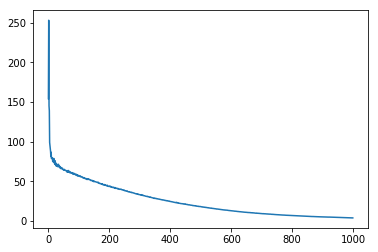

In [20]:
%matplotlib inline
plt.plot(losses)

## Inference on test 
Notice the batch prediction which is different to previous

In [21]:
rnn_model = build_graph(feed_previous=True, 
                        input_seq_len=input_seq_len, 
                        output_seq_len=output_seq_len, 
                        hidden_dim=hidden_dim, 
                        input_dim=input_dim, 
                        output_dim=output_dim, 
                        num_stacked_layers=num_stacked_layers, 
                        learning_rate=learning_rate,
                        lambda_l2_reg=lambda_l2_reg,
                        GRADIENT_CLIPPING=GRADIENT_CLIPPING)

In [22]:
init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('./seq2seq/new_multi_variable_model_results/', 'multivariate_ts_pollution_case'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from ./seq2seq/new_multi_variable_model_results/multivariate_ts_pollution_case
Test mse is:  2.1256423768378623


In [23]:
print("Shape of predictions is ",final_preds.shape)

Shape of predictions is  (17, 48, 105)


### Example of many featutres

In [9]:
output_features = []
for station in station_list : 
    for aq_feature in y_aq_list :
        output_features.append(station + "_" + aq_feature)

output_features.sort()

In [13]:
print(output_features)
print("Number of features is : ", len(output_features))

['aotizhongxin_aq_O3', 'aotizhongxin_aq_PM10', 'aotizhongxin_aq_PM2.5', 'badaling_aq_O3', 'badaling_aq_PM10', 'badaling_aq_PM2.5', 'beibuxinqu_aq_O3', 'beibuxinqu_aq_PM10', 'beibuxinqu_aq_PM2.5', 'daxing_aq_O3', 'daxing_aq_PM10', 'daxing_aq_PM2.5', 'dingling_aq_O3', 'dingling_aq_PM10', 'dingling_aq_PM2.5', 'donggaocun_aq_O3', 'donggaocun_aq_PM10', 'donggaocun_aq_PM2.5', 'dongsi_aq_O3', 'dongsi_aq_PM10', 'dongsi_aq_PM2.5', 'dongsihuan_aq_O3', 'dongsihuan_aq_PM10', 'dongsihuan_aq_PM2.5', 'fangshan_aq_O3', 'fangshan_aq_PM10', 'fangshan_aq_PM2.5', 'fengtaihuayuan_aq_O3', 'fengtaihuayuan_aq_PM10', 'fengtaihuayuan_aq_PM2.5', 'guanyuan_aq_O3', 'guanyuan_aq_PM10', 'guanyuan_aq_PM2.5', 'gucheng_aq_O3', 'gucheng_aq_PM10', 'gucheng_aq_PM2.5', 'huairou_aq_O3', 'huairou_aq_PM10', 'huairou_aq_PM2.5', 'liulihe_aq_O3', 'liulihe_aq_PM10', 'liulihe_aq_PM2.5', 'mentougou_aq_O3', 'mentougou_aq_PM10', 'mentougou_aq_PM2.5', 'miyun_aq_O3', 'miyun_aq_PM10', 'miyun_aq_PM2.5', 'miyunshuiku_aq_O3', 'miyunshuiku_

In [14]:
# 预测值普遍在 O3 上表现较好，另外两个参数　PM2.5 和　PM10 上通常捕捉不到高频分量
for i in range(len(output_features)):
    plot_forecast_and_actual_example(test_x, test_y, final_preds, output_features, index=0, feature_index=i)

NameError: name 'final_preds' is not defined

### 某个特征在整个dev数据集时间跨度上的表现

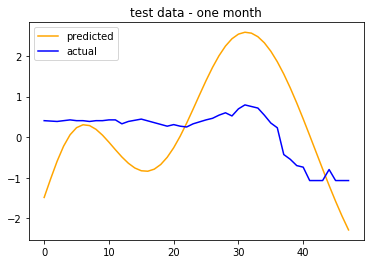

In [16]:
feature_index = 0
test_y_expand = np.concatenate([test_y[i,:,feature_index] for i in range(0, test_y.shape[0])], axis = 0)
final_preds_expand = np.concatenate([final_preds[i,:,feature_index] for i in range(0, final_preds.shape[0])], axis = 0)
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("test data - one month")
plt.legend(loc="upper left")
plt.show()

### Smapes of all features

载入训练样本的统计量

In [2]:
statistics = get_training_statistics()

In [3]:
statistics

,nongzhanguan_aq_PM2.5,nongzhanguan_aq_PM10,nongzhanguan_aq_NO2,nongzhanguan_aq_CO,nongzhanguan_aq_O3,nongzhanguan_aq_SO2,guanyuan_aq_PM2.5,guanyuan_aq_PM10,guanyuan_aq_NO2,guanyuan_aq_CO,...,yongledian_aq_temperature,yongledian_aq_pressure,yongledian_aq_humidity,yongledian_aq_wind_direction,yongledian_aq_wind_speed/kph,pinggu_aq_temperature,pinggu_aq_pressure,pinggu_aq_humidity,pinggu_aq_wind_direction,pinggu_aq_wind_speed/kph
label,,,,,,,,,,,,,,,,,,,,,
mean,60.270570,86.508707,49.520916,0.899456,54.615590,9.481894,59.297337,82.459596,50.657468,0.842730,...,11.554599,1016.679121,39.773854,197.015301,10.927671,10.591484,1001.588230,41.778629,193.124596,9.122660
std,65.838131,101.805670,31.605348,0.939021,53.782121,11.688182,62.905273,99.656668,30.790255,0.811781,...,11.763167,10.291141,21.658970,102.824005,6.459728,11.806261,9.558372,20.982975,111.122848,6.125807


计算 smape

In [42]:
aver_smapes, smapes_of_features = SMAPE_on_dataset(test_y, final_preds, output_features, statistics, 24)

NameError: name 'y_mean' is not defined

In [26]:
# smape value on all features
smapes_of_features

{'aotizhongxin_aq_O3': 0.9033747953147865,
 'aotizhongxin_aq_PM10': 0.5718946270291979,
 'aotizhongxin_aq_PM2.5': 0.7457085716015857,
 'badaling_aq_O3': 0.8041749469633239,
 'badaling_aq_PM10': 0.5564821160654873,
 'badaling_aq_PM2.5': 0.7049697537670129,
 'beibuxinqu_aq_O3': 1.0420253121274101,
 'beibuxinqu_aq_PM10': 0.5902215043625896,
 'beibuxinqu_aq_PM2.5': 0.7866312659997835,
 'daxing_aq_O3': 0.9610806103375031,
 'daxing_aq_PM10': 0.5462000516832216,
 'daxing_aq_PM2.5': 0.7143493858469224,
 'dingling_aq_O3': 0.6047706707798631,
 'dingling_aq_PM10': 0.5550950702163014,
 'dingling_aq_PM2.5': 0.8088193923510388,
 'donggaocun_aq_O3': 0.6080458117167155,
 'donggaocun_aq_PM10': 0.5778800265374652,
 'donggaocun_aq_PM2.5': 0.705846603198253,
 'dongsi_aq_O3': 0.9123188588253756,
 'dongsi_aq_PM10': 0.5068988974290636,
 'dongsi_aq_PM2.5': 0.6625081860635338,
 'dongsihuan_aq_O3': 1.0957649180244609,
 'dongsihuan_aq_PM10': 0.7569836099165018,
 'dongsihuan_aq_PM2.5': 0.7288406831512004,
 'fangs

In [27]:
print("The average smape on all features in the dev set is : ",aver_smapes)

The average smape on all features in the dev set is :  0.7111534524687351


# ChangeLog
- 0427 v0
    - 完成了第一版本模型